Mean value -1.5053 rad, RMS value 1.4209 rad, Range 5.9291 rad


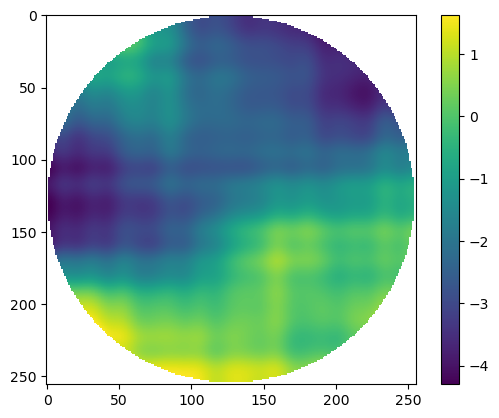

In [27]:
##Trying out three different interferometers

#interferometer 5+1 

#Modélisation de la turbulenc
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 256 # array size to work on

# set up arrays and plot some simple figures
xg, yg = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
rg = np.sqrt(xg ** 2 + yg ** 2)
theta = np.arctan2(yg, xg)
mask = (rg <= 1)

# create a random image with low spatial frequency content
ri = np.random.rand(N // 10, N // 10) - 0.5
kern = scipy.ndimage.zoom( np.exp(-rg * 2 / (2 * 0.25 * 2)), 0.1)
ro = scipy.signal.convolve2d(ri, kern, boundary='symm', mode='same')
ro_big = scipy.ndimage.zoom(ro, (N / ro.shape[0], N / ro.shape[1]))
phase = np.ma.masked_array(ro_big, ~mask)
plt.imshow(phase)
plt.colorbar()
print(f'Mean value {np.mean(phase):.4f} rad,', 
      f'RMS value {np.std(phase):.4f} rad,', 
      f'Range {(phase.max() - phase.min()):.4f} rad')
testwf = np.exp(1j * phase)



Mean value 0.1066  RMS value 1.8582  Range 12.4970 


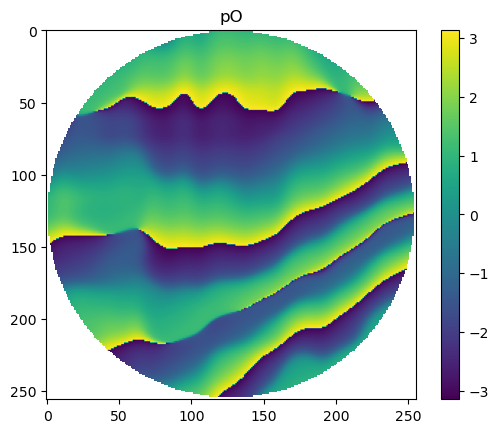

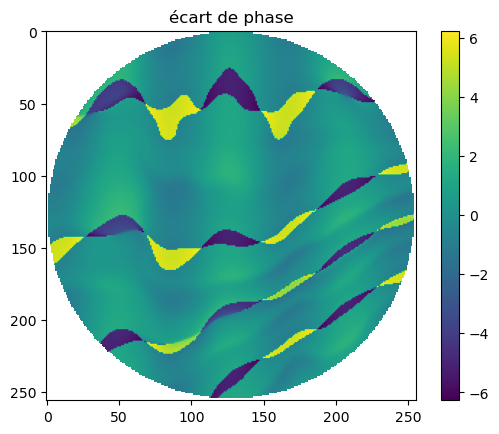

In [18]:
# 3 step PSI algorithm With Noise(Error = 0)
pstep = np.pi / 3
refphase = 5 * xg + 8 * yg
Error = 0.02*np.pi
Extraphase= np.cos(10*xg)
NoiseIntensity = 0
Loss=1
##type A

I01 = np.abs(np.exp(1j * (refphase) + testwf)) ** 2
I02 = np.abs(np.exp(1j * (refphase + pstep)) + testwf) ** 2
I03 = np.abs(np.exp(1j * (refphase + 2 * pstep)) + testwf) ** 2
I04 = np.abs(np.exp(1j * (refphase + 3 * pstep)) + testwf) ** 2
I05 = np.abs(np.exp(1j * (refphase + 4 * pstep)) + testwf) ** 2
             

pO=np.arctan2(2*(I04-I02),(I01-2*I03+I05))
plt.figure()
plt.imshow(pO)
plt.colorbar()
plt.title('pO')

Incorrect_refphase = refphase + Error + Extraphase
I1 = Loss*np.abs(np.exp(1j * (Incorrect_refphase)) + testwf) ** 2
I2 = np.abs(np.exp(1j * (Incorrect_refphase + pstep)) + testwf) ** 2
I3 = Loss*np.abs(np.exp(1j * (Incorrect_refphase + 2 * pstep)) + testwf) ** 2
I4 = np.abs(np.exp(1j * (Incorrect_refphase + 3 * pstep)) + testwf) ** 2
I5 = np.abs(np.exp(1j * (Incorrect_refphase + 4 * pstep)) + testwf) ** 2



p=np.arctan2(2*(I4-I2),(I1-2*I3+I5))
pdif=p-pO
plt.figure()
plt.imshow(pdif)
plt.colorbar()
plt.title('écart de phase')

print(f'Mean value {np.mean(pdif):.4f} ', 
      f'RMS value {np.std(pdif):.4f} ', 
      f'Range {(pdif.max() - pdif.min()):.4f} ')



Mean value -0.1055  RMS value 1.9442  Range 12.5280 


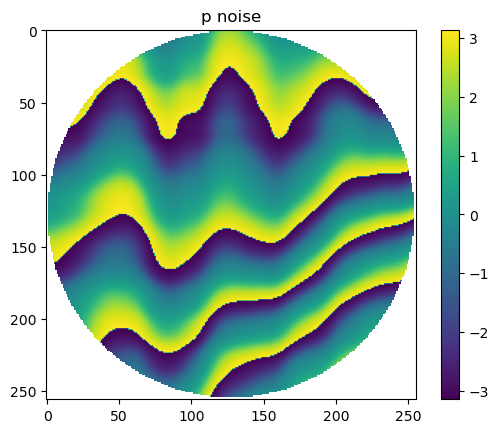

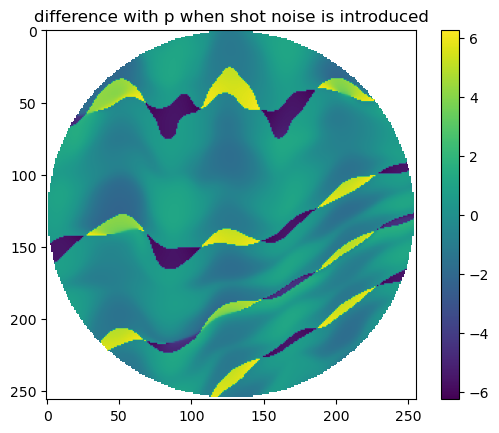

In [22]:
signal_levels = [np.mean(I1), np.mean(I2), np.mean(I3),np.mean(I4), np.mean(I5)]

poisson_noise_I1 = np.random.poisson(np.sqrt(signal_levels[0]), size=I1.shape)
poisson_noise_I2 = np.random.poisson(np.sqrt(signal_levels[1]), size=I2.shape)
poisson_noise_I3 = np.random.poisson(np.sqrt(signal_levels[2]), size=I3.shape)
poisson_noise_I4 = np.random.poisson(np.sqrt(signal_levels[3]), size=I4.shape)
poisson_noise_I5 = np.random.poisson(np.sqrt(signal_levels[4]), size=I5.shape)



NoiseI1 = I1 + NoiseIntensity * poisson_noise_I1
NoiseI2 = I2 + NoiseIntensity * poisson_noise_I2
NoiseI3 = I3 + NoiseIntensity * poisson_noise_I3
NoiseI4 = I4 + NoiseIntensity * poisson_noise_I4
NoiseI5 = I5 + NoiseIntensity * poisson_noise_I5




p_noise=np.arctan2((NoiseI4-NoiseI2),(NoiseI1-2*NoiseI3+NoiseI5))

plt.figure()
plt.imshow(p_noise)
plt.colorbar()
plt.title('p noise')

pdif2=pO-p_noise

plt.figure()
plt.imshow(pdif2)
plt.colorbar()
plt.title('difference with p when shot noise is introduced')
print(f'Mean value {np.mean(pdif2):.4f} ', 
      f'RMS value {np.std(pdif2):.4f} ', 
      f'Range {(pdif2.max() - pdif2.min()):.4f} ')

Mean value 2.6798 rad, RMS value 13.1919 rad, Range 55.7575 rad


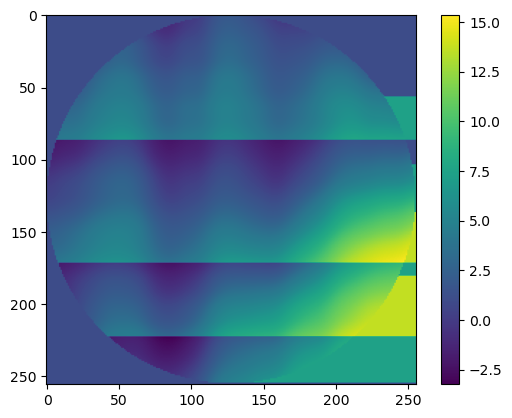

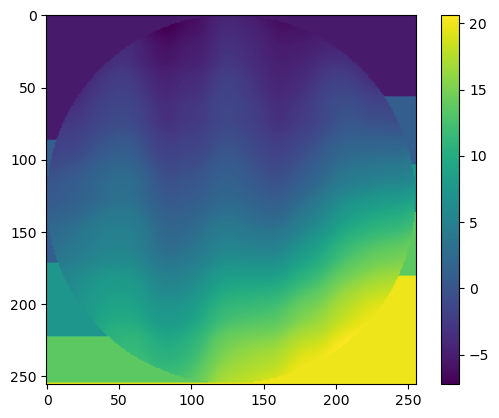

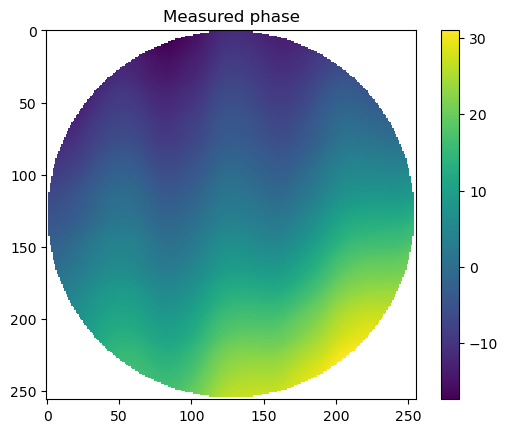

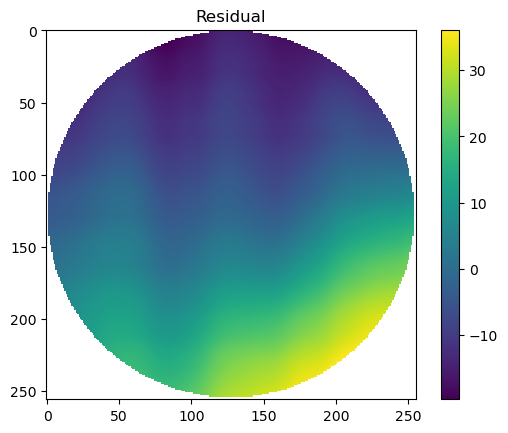

In [23]:
# try to unwrap the phase
plt.figure()
plt.imshow(np.unwrap(np.unwrap(p, axis=0), axis=1))
plt.colorbar()

# try to unwrap phase from middle out half of image at a time
q = np.zeros_like(p)
q[N // 2:, :] = np.unwrap(p[N // 2:,:], axis=0)
q[N // 2::-1, :] = np.unwrap(p[N // 2::-1, :], axis=0)
q[:, N // 2:] = np.unwrap(q[:, N // 2:], axis=1)
q[:, N // 2::-1] = np.unwrap(q[:, N // 2::-1], axis=1)
plt.figure()
plt.imshow(q)
plt.colorbar()

# take off tilt to see what is left
plt.figure()
measured_phase = np.ma.masked_array(q + Incorrect_refphase, ~mask)
plt.imshow(measured_phase)
plt.colorbar()
plt.title('Measured phase')

# take off aberration to see what is left
plt.figure()
residual = measured_phase - phase 
plt.imshow(residual)
plt.colorbar()
plt.title('Residual')
print(f'Mean value {np.mean(residual):.4f} rad,', 
      f'RMS value {np.std(residual):.4f} rad,', 
      f'Range {(residual.max() - residual.min()):.4f} rad')

Mean value 0.0000 rad, RMS value 0.0000 rad, Range 0.0000 rad


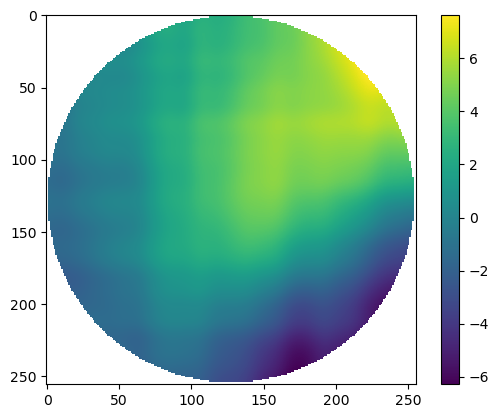

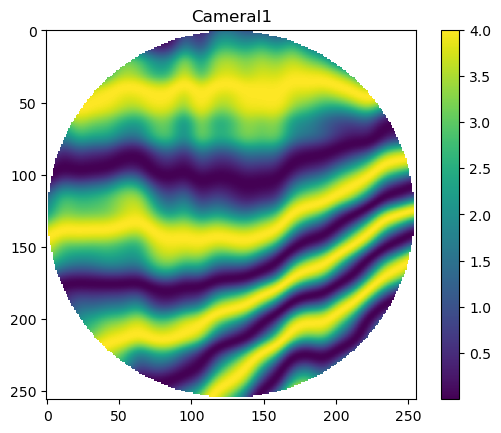

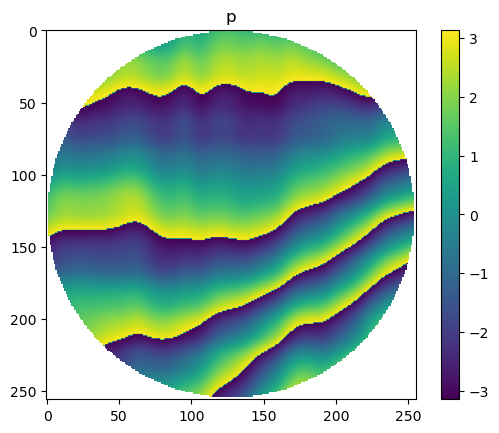

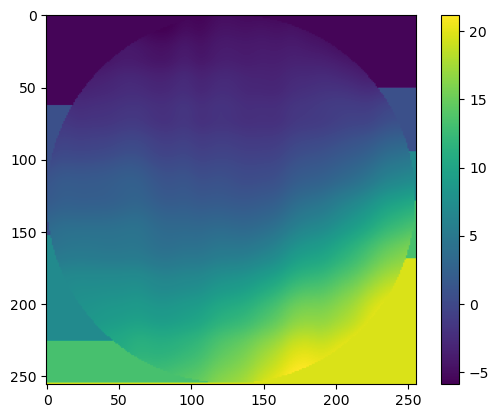

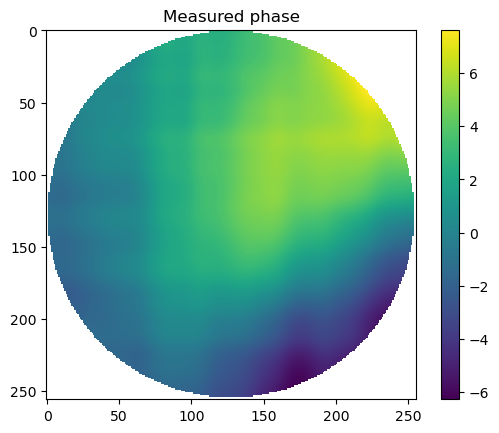

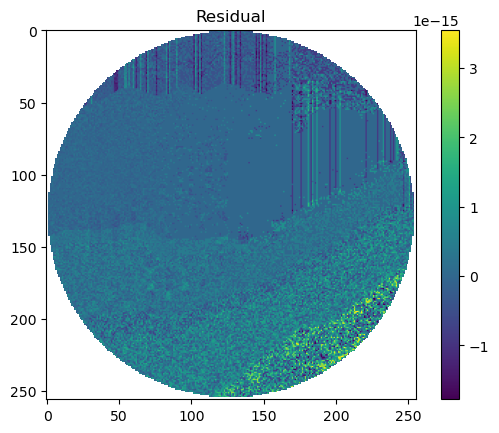

In [24]:
# Hariharan step PSI algorithm for phase shift error
plt.imshow(phase)
plt.colorbar()
pstep = np.pi / 2
refphase = 5 * xg + 8 * yg
Error = 1.8 * np.pi
Gamma = 1   # Gamma = 1,2,0.5,0.3

Incorrect_refphase = refphase + Error
I1 = np.abs(np.exp(1j * (Incorrect_refphase - 2 * pstep)) + testwf) ** 2
I2 = np.abs(np.exp(1j * (Incorrect_refphase - pstep)) + testwf) ** 2
I3 = np.abs(np.exp(1j * (Incorrect_refphase)) + testwf) ** 2
I4 = np.abs(np.exp(1j * (Incorrect_refphase + pstep)) + testwf) ** 2
I5 = np.abs(np.exp(1j * (Incorrect_refphase + 2 * pstep)) + testwf) ** 2

CameraI1 = I1 ** Gamma
CameraI2 = I2 ** Gamma
CameraI3 = I3 ** Gamma
CameraI4 = I4 ** Gamma
CameraI5 = I5 ** Gamma

plt.figure()
plt.imshow(CameraI1)
plt.colorbar()
plt.title('CameraI1')

u = 2 * (CameraI2 - CameraI4)
v = 2 * CameraI3 - CameraI5 - CameraI1

p = np.arctan2(u,v);
plt.figure()
plt.imshow(p)
plt.colorbar()
plt.title('p')

# try to unwrap phase from middle out half of image at a time
q = np.zeros_like(p)
q[N // 2:, :] = np.unwrap(p[N // 2:,:], axis=0)
q[N // 2::-1, :] = np.unwrap(p[N // 2::-1, :], axis=0)
q[:, N // 2:] = np.unwrap(q[:, N // 2:], axis=1)
q[:, N // 2::-1] = np.unwrap(q[:, N // 2::-1], axis=1)
plt.figure()
plt.imshow(q)
plt.colorbar()

# take off tilt to see what is left
plt.figure()
measured_phase = np.ma.masked_array(- q + Incorrect_refphase, ~mask)
plt.imshow(measured_phase)
plt.colorbar()
plt.title('Measured phase')

# take off aberration to see what is left
plt.figure()
residual = measured_phase - phase 
plt.imshow(residual)
plt.colorbar()
plt.title('Residual')
print(f'Mean value {np.mean(residual):.4f} rad,', 
      f'RMS value {np.std(residual):.4f} rad,', 
      f'Range {(residual.max() - residual.min()):.4f} rad')

Mean value 0.0000 rad, RMS value 0.0000 rad, Range 0.0000 rad


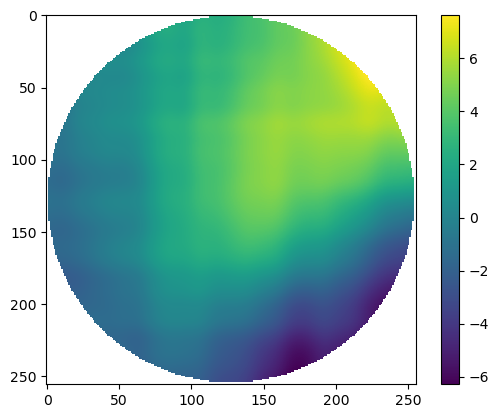

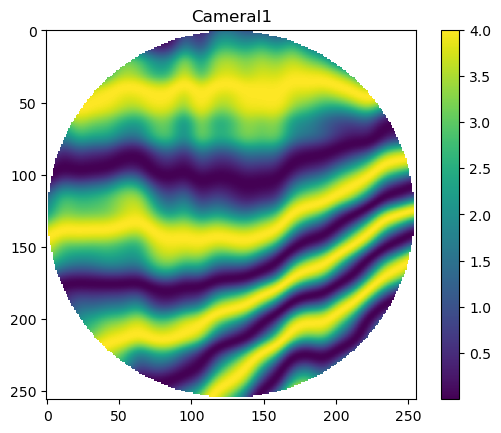

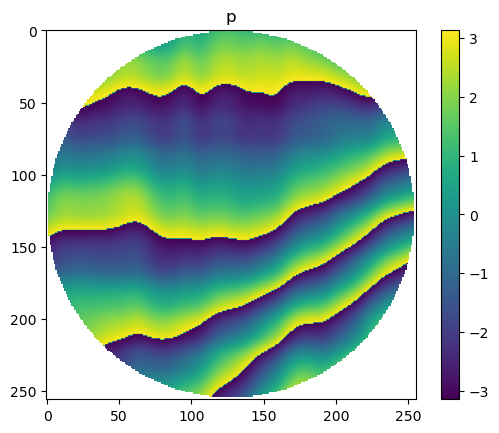

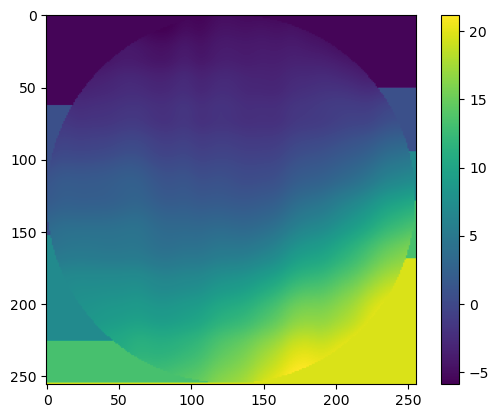

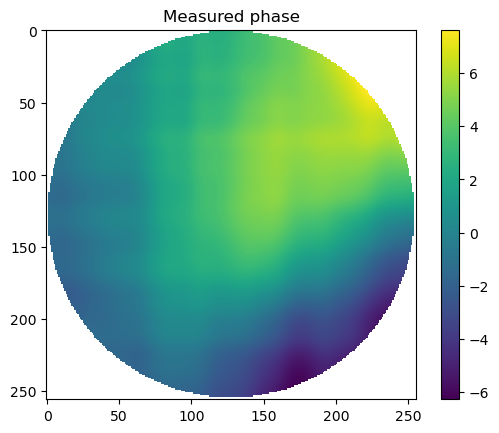

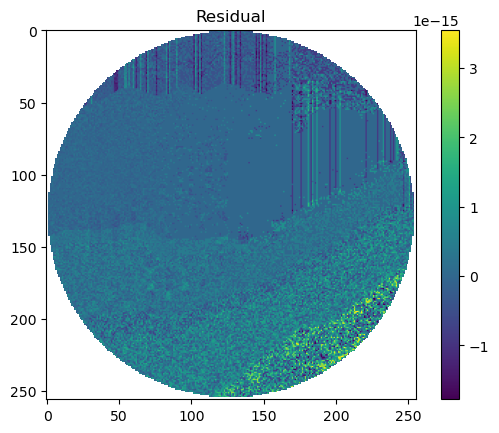

Mean value -0.0081 rad, RMS value 0.0845 rad, Range 0.3563 rad


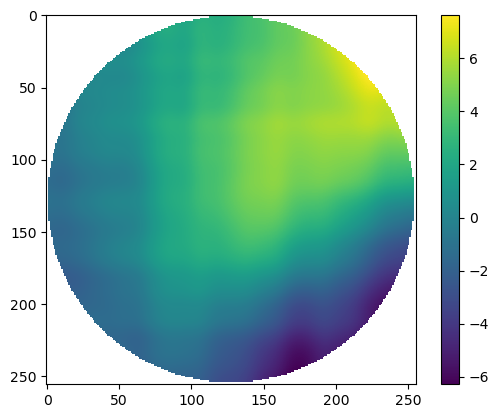

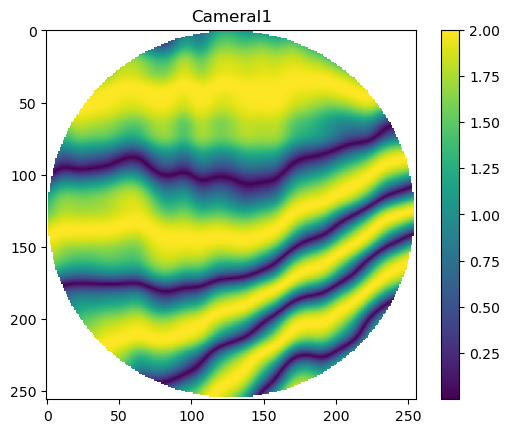

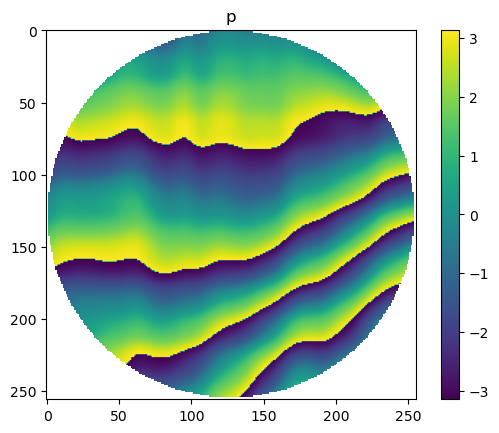

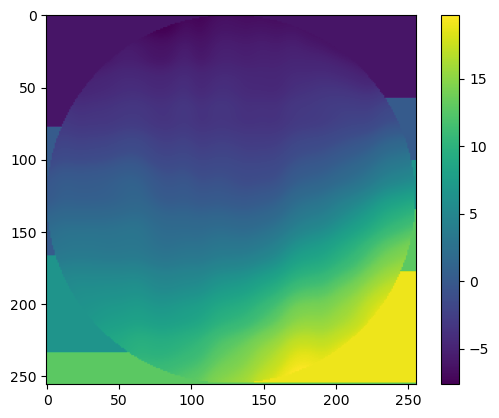

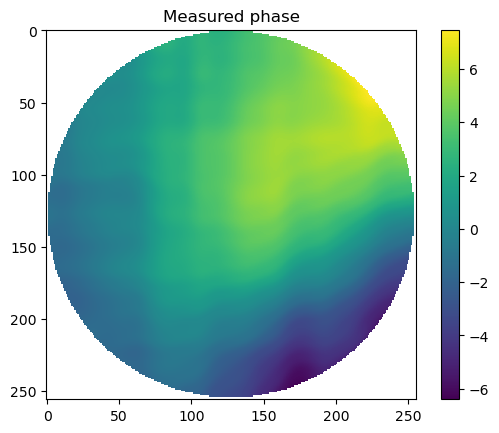

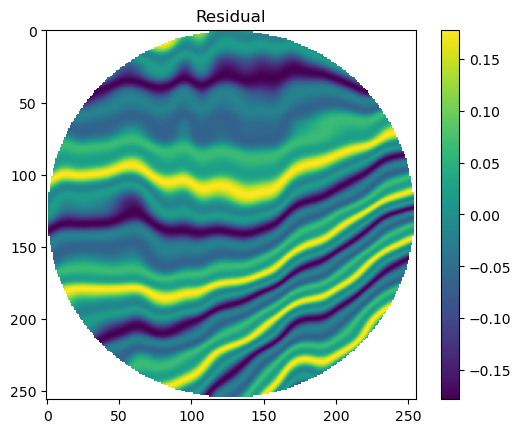

In [26]:
# N=7 de Groot (Page 595 on the book)
plt.imshow(phase)
plt.colorbar()
pstep = np.pi / 2
refphase = 5 * xg + 8 * yg
Error = 1.3 * np.pi
Gamma = 0.5   # Gamma = 1,2,0.5,0.3

Incorrect_refphase = refphase + Error
I1 = np.abs(np.exp(1j * (Incorrect_refphase - 5 * pstep)) + testwf) ** 2
I2 = np.abs(np.exp(1j * (Incorrect_refphase - 4 * pstep)) + testwf) ** 2
I3 = np.abs(np.exp(1j * (Incorrect_refphase - 3 * pstep)) + testwf) ** 2
I4 = np.abs(np.exp(1j * (Incorrect_refphase - 2 * pstep)) + testwf) ** 2
I5 = np.abs(np.exp(1j * (Incorrect_refphase - 1 * pstep)) + testwf) ** 2
I6 = np.abs(np.exp(1j * (Incorrect_refphase + 0 * pstep)) + testwf) ** 2
I7 = np.abs(np.exp(1j * (Incorrect_refphase + 1 * pstep)) + testwf) ** 2
I8 = np.abs(np.exp(1j * (Incorrect_refphase + 2 * pstep)) + testwf) ** 2
I9 = np.abs(np.exp(1j * (Incorrect_refphase + 3 * pstep)) + testwf) ** 2
I10 = np.abs(np.exp(1j * (Incorrect_refphase + 4 * pstep)) + testwf) ** 2
I11 = np.abs(np.exp(1j * (Incorrect_refphase + 5 * pstep)) + testwf) ** 2


CameraI1 = I1 ** Gamma
CameraI2 = I2 ** Gamma
CameraI3 = I3 ** Gamma
CameraI4 = I4 ** Gamma
CameraI5 = I5 ** Gamma
CameraI6 = I6 ** Gamma
CameraI7 = I7 ** Gamma
CameraI8 = I8 ** Gamma
CameraI9 = I9 ** Gamma
CameraI10 = I10 ** Gamma
CameraI11 = I11 ** Gamma

plt.figure()
plt.imshow(CameraI1)
plt.colorbar()
plt.title('CameraI1')


# for arctan2
u = (CameraI1 - CameraI11) - 8 * (CameraI3 - CameraI9) + 15 * (CameraI5 - CameraI7)
v = (4 * CameraI2 + CameraI10) - 12 * (CameraI4 + CameraI8) + 16 * CameraI6 

p = np.arctan2(u,v);
plt.figure()
plt.imshow(p)
plt.colorbar()
plt.title('p')

# try to unwrap phase from middle out half of image at a time
q = np.zeros_like(p)
q[N // 2:, :] = np.unwrap(p[N // 2:,:], axis=0)
q[N // 2::-1, :] = np.unwrap(p[N // 2::-1, :], axis=0)
q[:, N // 2:] = np.unwrap(q[:, N // 2:], axis=1)
q[:, N // 2::-1] = np.unwrap(q[:, N // 2::-1], axis=1)
plt.figure()
plt.imshow(q)
plt.colorbar()

# take off tilt to see what is left
plt.figure()
measured_phase = np.ma.masked_array(- q + Incorrect_refphase, ~mask)
plt.imshow(measured_phase)
plt.colorbar()
plt.title('Measured phase')

# take off aberration to see what is left
plt.figure()
residual = measured_phase - phase 
plt.imshow(residual)
plt.colorbar()
plt.title('Residual')
print(f'Mean value {np.mean(residual):.4f} rad,', 
      f'RMS value {np.std(residual):.4f} rad,', 
      f'Range {(residual.max() - residual.min()):.4f} rad')